# Temporal Compression Study

##Overview

This study investigates the relationship between multiple spatial and phenomenological variables on how people simulate movement through a recently learned virtual city. Specifically, we're interested in whether temporal information derived from previous experiences is contained in predictive mental simulations. We identified three primary research questions and evaluate them across two studies.

**Research Q1:** Is temporal information from memories recapitulated during mental simulations? If so, is it preserved based on previous experiences (1:1 ratio), or is it temporally compressed similar to predictive place cell dynamics in the rodent hippocampus?

**Research Q2:** Is the degree of temporal compression static, or adaptive to accomodate changes in the speed of exposure to visual stimuli during encoding?

**Research Q3:** Does the fidelity of a mental simulation relate to the ability to make predictions off it?

In [1]:
#import libraries for data analysis
%pylab
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from PIL import Image

#set graph options
%matplotlib inline
sns.set_context('talk')
sns.set_style('darkgrid')

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


##1. Study 1

This study uses a base movement speed of 6 virtual m/s in Unity3D.

###1.1 Import and Format Matrix

In [2]:
# import performance data
import_p_data = pd.read_csv('medium_performance.csv', index_col = 0)

# clone for data manipulation
p_data = import_p_data

# format dataframe index
range_list = list(range(0,len(p_data)))
p_data = p_data.set_index([range_list])

###1.2 Filtering Lost Trials

We will filter our data using two common methods and observe how the distribution looks. First, we'll remove the routes in the top quartile of difference scores. Second, we'll remove only routes that are more than 3 standard deviations from the mean difference scores. Before then, let's calculate the differences between the recorded path times for each trial and their optimal time. Using difference scores let's leaves us unbiased against filtering out longer paths that would necessitate longer path times.

####1.2.1 Difference Scores

In order to filter trials, we want to isolate trails which are the most likely candidates for ones in which the participant got lost. To do this, we'll calculate a new variable that codes the difference between the observed route time and the optimal route time. This will remove variance in route time due to the length of the route (some routes are longer than others) and allow us to focus on just the excess time over and above the base time needed to navigate a route.

In [3]:
# load optimal route times
opt = pd.read_csv('Optimal.csv')
print "The mean optimal route time is {}".format(opt['Optimal'].mean())

The mean optimal route time is 24.853


In [4]:
# clone optimal route time vector
opt_temp = opt

# clone vector for each participant
counter = len(p_data['Participant'].unique())

# expand optimal vector to match length of p_data
while counter > 1:
    opt = opt.append(opt_temp)
    counter = counter -1
    
# reformat optimal index
ind_list = list(range(0,len(p_data)))
opt = opt.set_index([ind_list])

# join dataframes
p_data = p_data.join(opt)

# calculate new vector containing difference between path time and optimal time
p_data['Diff'] = np.NaN

for i in ind_list:
    p_data.loc[i, 'Diff'] = p_data.loc[i, 'Path_Time'] - p_data.loc[i, 'Optimal']

Now let's summarize the distribution of difference scores.

count    280.000000
mean      23.395358
std       38.130426
min        3.719600
25%        9.283330
50%       12.762850
75%       21.660375
max      463.742600
Name: Diff, dtype: float64


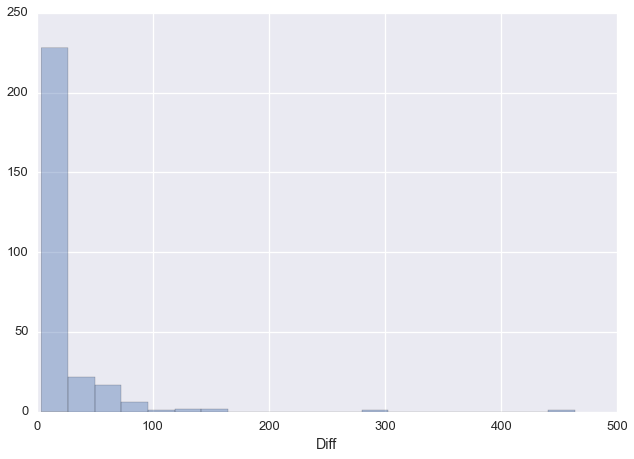

In [5]:
print(p_data.Diff.describe())
sns.distplot(p_data.Diff.dropna(), kde=False, bins=20);

#### Figure 1. Distribution of difference scores

From this histogram, it is evident that most trails are under 20 seconds with some greatly exceeding this.

####1.2.2 Top Quartile Filter

First, we're going to remove the top quartile, which means any trial with a difference score that exceeds 14.95 seconds.

In [6]:
# clone p_data for manipulation
d75 = p_data.copy()

# remove trials with differences above the 75% cut off
cutoff = d75.Diff.quantile(.75)
columns = list(d75.columns.values)

for c in columns:
    for i, r in d75.iterrows():
        if r[d75.columns.get_loc('Diff')] > cutoff:
            d75.loc[i, c] = np.NaN   

####1.2.3 Three Standard Deviations Filter

Next, we're going to remove all trials that exceed 3 standard deviations on the difference scores. Note that this is a much more conservative filter as it only removes trials with difference scores greater than 58.48 seconds, which is approximately double what the mean optimal route time is (i.e. these trails took 3 times as long as they should to navigate).

In [7]:
# clone p_data for manipulation
d3 = p_data.copy()

# remove trials with differences above the 3 standard deviation cut off
cutoff = d3.Diff.std()*3
columns = list(d3.columns.values)

for c in columns:
    for i, r in d3.iterrows():
        if r[d3.columns.get_loc('Diff')] > cutoff:
            d3.loc[i, c] = np.NaN  

####1.2.4 Comparison of filters

We can now compare the remaining data between filter strategies.

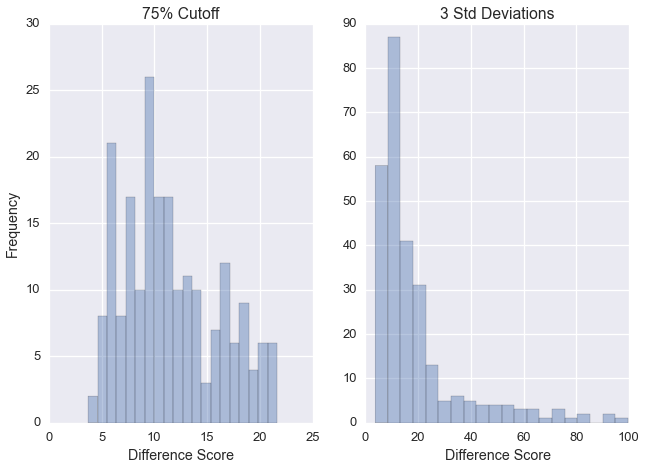

In [8]:
# plot data after filtering the top 25% difference values
plt.subplot(121)
sns.distplot(d75.Diff.dropna(), kde=False, bins=20)
plt.xlabel('Difference Score')
plt.ylabel('Frequency')
plt.title('75% Cutoff')
# plot data after filtering any difference score over 3 standard deviations
plt.subplot(122)
sns.distplot(d3.Diff.dropna(), kde=False, bins=20)
plt.xlabel('Difference Score')
plt.title('3 Std Deviations')

####Figure 2. Comparison of difference scores after filtering

From these plots, we can see that the 3 standard deviation filter leaves a number of trials with differences scores >40 seconds, which is over twice as long as each trial should take on average. Because of this, we'll use the 75% filter, but will also compare our statistics to the 3 standard deviation filter.

###1.3 Descriptive Statistics

####1.3.1 Demographic Information

This section provides a summary of the demographic information we collected prior to the experiment.

In [9]:
# import demographic data
import_d_data = pd.read_csv('medium_survey.csv')

# select relevant data
dem_data = import_d_data.loc[:,:'SBSOD']

# summarize demographic data
dem_summary = np.round(dem_data.describe(), decimals = 2)

# create table
dem_summary

,Age,Education,V_week,V_age,SBSOD
count,28.00,28.00,28.00,28.00,28.0
mean,19.64,13.79,4.16,7.89,4.8
std,1.87,1.57,7.93,3.53,0.9
min,15.00,12.00,0.00,0.00,3.0
25%,18.00,12.00,0.00,6.00,4.0
50%,19.50,14.00,0.75,8.00,5.0
75%,20.25,15.00,6.00,10.00,5.5
max,24.00,17.00,40.00,16.00,6.5


####Table 1. Descriptive stats for demographics

Education is calculated as high school (12) plus post secondary. V_week denotes hours spent playing video games per week. V_age denotes age the participant first started playing video games. SBSOD stands for the Santa Barbara Sense of Direction Scale (Hegarty et al., 2002).

####1.3.2 Task Performance

In this section, variables measuring different aspects of performance on the simulation phase of the experiment are summarized.

In [10]:
# create new dataframe for task variables
t_data = d75.loc[:, 'Path_Time':'Sim_Time']

# summarize simulation data
t_summary = np.round(t_data.describe(), decimals = 2)

# create table
t_summary

,Path_Time,Distance,RT,Sim_Time
count,210.00,210.00,190.00,210.00
mean,35.81,189.91,3.34,14.41
std,9.25,55.52,1.54,11.21
min,20.92,117.77,1.24,0.02
25%,28.17,140.47,2.35,6.29
50%,34.11,176.47,2.94,10.35
75%,41.05,223.63,3.90,19.72
max,58.92,324.59,10.62,55.23


####Table 2. Descriptive statistics for performance variables

These data are from 10 routes navigated by each participant. Sim Time denotes the amount of time they took to simulate the route.

Next, we look at the qualitative variables that were measured during the post-simulation questionnaire.

####1.3.3 Simulation Variables

In [11]:
# select relevant columns
s_data = d75.loc[:, 'Vividness':]

# summarize simulation data
s_summary = np.round(s_data.describe(), decimals = 2)

# create table
s_summary

,Vividness,S_coherence,T_coherence,Fract,Coherence,Length,S_mem,G_mem,Optimal,Diff
count,210.00,210.00,210.00,210.00,210.00,210.00,210.00,210.00,210.00,210.00
mean,3.78,3.51,3.49,3.63,3.57,2.62,4.46,4.32,24.25,11.56
std,1.05,1.33,1.20,0.97,0.92,1.29,0.97,1.06,6.31,4.47
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,17.20,3.72
25%,3.33,3.00,2.25,3.00,3.00,1.00,4.00,4.00,19.15,8.03
50%,4.00,4.00,4.00,3.50,3.50,3.00,5.00,5.00,21.80,10.65
75%,4.63,5.00,4.00,4.50,4.25,4.00,5.00,5.00,31.20,14.57
max,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,37.72,21.63


#### Table 3. Descriptive statistics for simulation variables

These are calculated by combining the rating (1-5 likert scale) on different questions into categories. High scores (5) indicates this category was well represented in the simulation.

* S_coherence = spatial coherence
* T_coherence = temporal coherence
* Fract = fluidity of simulation (i.e. like a movie or a series of pictures)
* Coherence = general coherence
* S_mem = memory of starting location
* G_mem = memory of goal location

###1.4 Mean Centering Simulation Time

Before the data is further analyzed, it is important to mean-center the simulation times for each participant. The reason for this is that we can then work with trial-by-trail variance in simulation time that is not biased by between subject differences in simulation time.

In [12]:
# function to mean center data into a new vector
def mean_center(matrix):    
    
    # create new column for mean centered sim times
    matrix['Sim_Centered'] = np.NaN

    # create a list of subject IDs
    sub_list = list(matrix['Participant'].unique())

    # ignore NaN columns
    del sub_list[sub_list.index(nan)]

    # loop through subjects
    for i in sub_list:

        # calculate subject mean of sim time by getting each participant's data individually and calculating the mean
        sub = matrix.groupby(['Participant']).get_group(i)
        mean = sub.loc[:, 'Sim_Time'].mean()

        # replace sim centered NaN with sim time value minus the mean
        for ind, row in matrix.iterrows():
            if row[matrix.columns.get_loc('Participant')] == i:
                matrix.loc[ind, 'Sim_Centered'] = row[matrix.columns.get_loc('Sim_Time')] - mean

# mean center data
mean_center(d75)

Next, let's compare the relationship between both the observed and mean-centered simulation times with path time

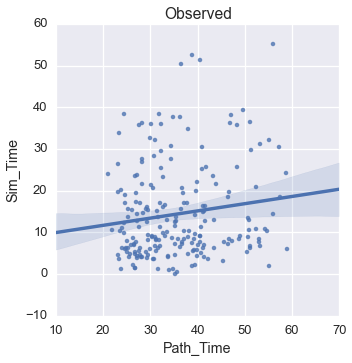

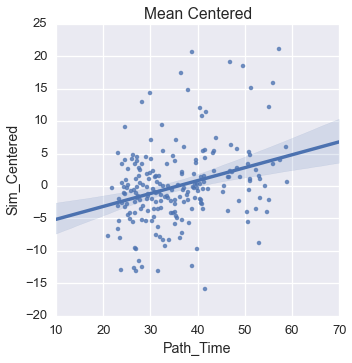

In [13]:
sns.lmplot("Path_Time", "Sim_Time", d75)
plt.title("Observed")
sns.lmplot("Path_Time", "Sim_Centered", d75)
plt.title("Mean Centered")

####Figure 3. Comparison of observed and mean centered simulation times

Evident in these plots is that there are trails in which participants are taking much longer to navigate a route than would be expected if they had properly navigated. To quantify this, we calculated the optimal route time by having the lead author navigate each path using the quickest shortcuts three times, and taking the fastest time for each route. We can now calculate what the mean optimal time is.

From this we can observe that there are numerous trials where the participant took 2-3x the optimal path time, indicating that they got lost during the route. In the next section, we'll use two different strategies to deal with these lost trials.

###1.5 Temporal Compression Rate

In this section we'll calculate the rate of temporal compression for each route. Here, we need to use the original simulation and route times for each trial to get an estimate of how much each simulation has been temporally compressed. We'll do this by taking the ratio of simulation time to path time.

In [14]:
# calculate temporal compression factor for the 75% filter
t_fact = d75.loc[:, 'Sim_Time'] / d75.loc[:, 'Path_Time']
print('The temporal compression factor for the 75% filter is {}.'.format(np.round(t_fact.mean(), 3)))

# calculate temporal compression factor for the 3 standard deviation filter
t_fact_std = d3.loc[:, 'Sim_Time'] / d3.loc[:, 'Path_Time']
print('The temporal compression factor for the 3 std dev filter is {}.'.format(np.round(t_fact_std.mean(), 3)))

The temporal compression factor for the 75% filter is 0.418.
The temporal compression factor for the 3 std dev filter is 0.368.


As we can see, the compression rate doesn't vary that much between the two filtering strategies. It also supports our first hypothesis that mental simulations are temporally compressed at a ~2.5x rate compared to the time needed to subsequently navigate the route. 

##2. Study Two - Manipulating Movement Speeds

In this study, we change the movement speed during the encoding phases to see if the rate at which visual stimuli is experienced interacts with the temporal compression rate. This addresses our second research question about whether the temporal compression rate is constant or adaptive. We introduced two new encoding speed movement conditions: a slow condition (4 virtual m/s) and a fast condition (8 virtual m/s). 

**Note that the movement speed was only changed for the encoding phase and not the simulation phase.** As such, no correction for path time is needed in the data.

###2.1 Import and Format Matrix

####2.1.1 Slow Movement Condition

In [ ]:
# import performance data
import_p_data_slow = pd.read_csv('slow_performance.csv', index_col = 0)

# clone for data manipulation
p_data_slow = import_p_data_slow

# format dataframe index
range_list = list(range(0,len(p_data_slow)))
p_data_slow = p_data_slow.set_index([range_list])

# remove two trials that have simulation times less than zero that resulted from measurement error
for i,r in p_data_slow.iterrows():
    if r['Sim_Time'] < 0:
        p_data_slow.loc[i,:] = np.NaN

####2.1.2 Fast Movement Condition

In [16]:
# import performance data
import_p_data_fast = pd.read_csv('fast_performance.csv', index_col = 0)

# clone for data manipulation
p_data_fast = import_p_data_fast

# format dataframe index
range_list = list(range(0,len(p_data_fast)))
p_data_fast = p_data_fast.set_index([range_list])

# remove two trials that have simulation times less than zero that resulted from measurement error
for i,r in p_data_fast.iterrows():
    if r['Sim_Time'] < 0:
        p_data_fast.loc[i,:] = np.NaN

###2.2. Demographics

####2.2.1 Slow Movement Condition

In [17]:
# import demographic data
import_d_data_slow = pd.read_csv('slow_survey.csv')

# select relevant data
dem_data_slow = import_d_data_slow.loc[:,:'SBSOD']

# summarize demographic data
dem_summary_slow = np.round(dem_data_slow.describe(), decimals = 2)

# create table
dem_summary_slow

,Age,Education,V_week,V_age,SBSOD
count,26.00,26.00,26.00,26.00,2.600000e+01
mean,20.19,12.73,3.81,7.15,2.553371e+13
std,1.58,3.76,6.17,3.79,9.339038e+12
min,18.00,3.00,0.00,0.00,9.698512e+12
25%,19.00,12.00,0.00,5.00,1.801400e+13
50%,20.00,14.00,0.50,6.50,2.362733e+13
75%,21.75,14.75,6.50,10.00,3.083066e+13
max,23.00,17.00,25.00,14.00,4.911185e+13


####Table 4. Demographics for the slow movement condition

####2.2.2 Fast Movement Condition

In [18]:
# import demographic data
import_d_data_fast = pd.read_csv('fast_survey.csv')

# select relevant data
dem_data_fast = import_d_data_fast.loc[:,:'SBSOD']

# summarize demographic data
dem_summary_fast = np.round(dem_data_fast.describe(), decimals = 2)

# create table
dem_summary_fast

,Age,Education,V_week,V_age,SBSOD
count,26.00,26.00,26.00,26.00,26.00
mean,20.92,12.46,7.77,8.08,3.65
std,1.92,3.75,11.67,3.21,1.02
min,18.00,3.00,0.00,0.00,2.00
25%,19.25,12.00,0.00,6.00,3.00
50%,21.00,13.00,3.50,8.00,4.00
75%,22.00,14.75,13.75,10.75,4.00
max,25.00,17.00,50.00,13.00,5.00


####Table 5. Demographics for the fast movement condition

###2.3 Filtering Lost Trials

####2.3.1 Slow Movement Condition - Top Quartile

In [23]:
#load optimal route times
opt = pd.read_csv('Optimal.csv')
opt_temp = opt

#clone vector for each participant and index it to zero
counter = len(p_data_slow['Participant'].unique()) - 1

#expand optimal vector to match length of p_data
while counter > 1:
    opt = opt.append(opt_temp)
    counter = counter - 1
    
#reformat optimal index
ind_list = list(range(0,len(p_data_slow)))

opt = opt.set_index([ind_list])

#join dataframes
p_data_slow = p_data_slow.join(opt)

#calculate new vector containing difference between path time and optimal time
p_data_slow['Diff'] = np.NaN

for i in ind_list:
    p_data_slow.loc[i, 'Diff'] = p_data_slow.loc[i, 'Path_Time'] - p_data_slow.loc[i, 'Optimal']

count    258.000000
mean      39.664225
std       40.467000
min       13.802100
25%       19.310900
50%       26.965600
75%       41.657825
max      373.663200
Name: Diff, dtype: float64


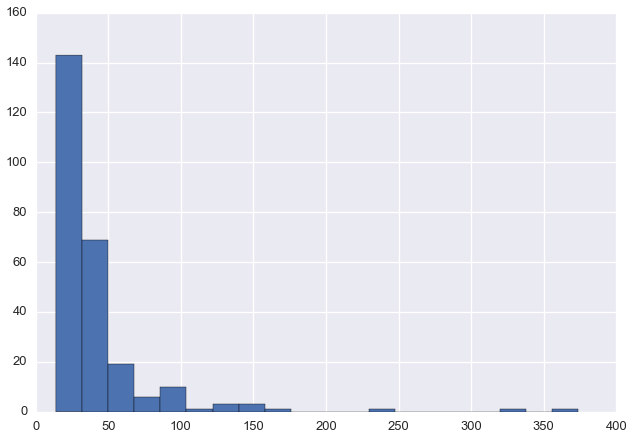

In [24]:
print(p_data_slow.Diff.describe())
plt.hist(p_data_slow.Diff.dropna(), 20);

####Figure 4. Distribution of difference times in the slow condition

Here we can see that the distribution of difference scores is similar to what we observed in study 1. As such, we'll apply the same filtering strategy to discard trials within the top quartile.

In [25]:
# clone p_data for manipulation
d75_slow = p_data_slow.copy()

# remove trials with differences above the 75% cut off
cutoff = d75_slow.Diff.quantile(.75)
columns = list(d75.columns.values)

for c in columns:
    for i, r in d75_slow.iterrows():
        if r[d75_slow.columns.get_loc('Diff')] > cutoff:
            d75_slow.loc[i, c] = np.NaN 

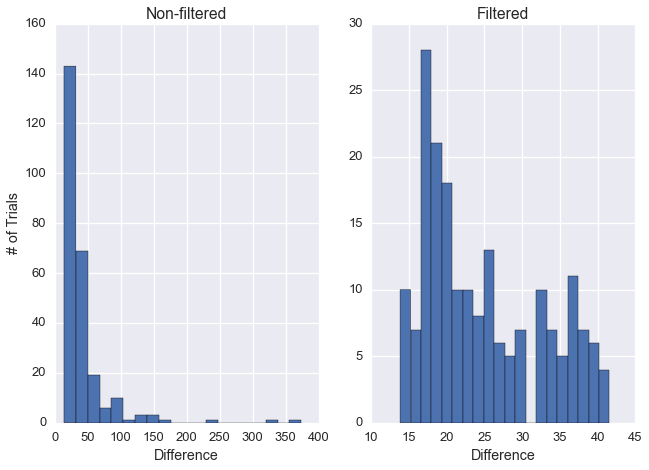

In [26]:
plt.subplot(121)
plt.hist(p_data_slow.Diff.dropna(), 20)
plt.title('Non-filtered')
plt.xlabel('Difference')
plt.ylabel('# of Trials')

plt.subplot(122)
plt.hist(d75_slow.Diff.dropna(), 20)
plt.title('Filtered')
plt.xlabel('Difference');

####Figure 5. Comparison of filtered and non-filtered distributions of difference times in the slow condition

####2.3.2 Fast Movement Condition - Top Quartile

In [27]:
# load optimal route times
opt = pd.read_csv('Optimal.csv')
opt_temp = opt

# clone vector for each participant
counter = len(p_data_fast['Participant'].unique()) - 1

# expand optimal vector to match length of p_data_fast
while counter > 1:
    opt = opt.append(opt_temp)
    counter = counter -1
    
# reformat optimal index
ind_list = list(range(0,len(p_data_fast)))
opt = opt.set_index([ind_list])

# join dataframes
p_data_fast = p_data_fast.join(opt)

# calculate new vector containing difference between path time and optimal time
p_data_fast['Diff'] = np.NaN

for i in ind_list:
    p_data_fast.loc[i, 'Diff'] = p_data_fast.loc[i, 'Path_Time'] - p_data_fast.loc[i, 'Optimal']

count    258.000000
mean      17.884645
std       26.910165
min        0.001800
25%        2.482700
50%        7.540800
75%       18.887583
max      160.290000
Name: Diff, dtype: float64


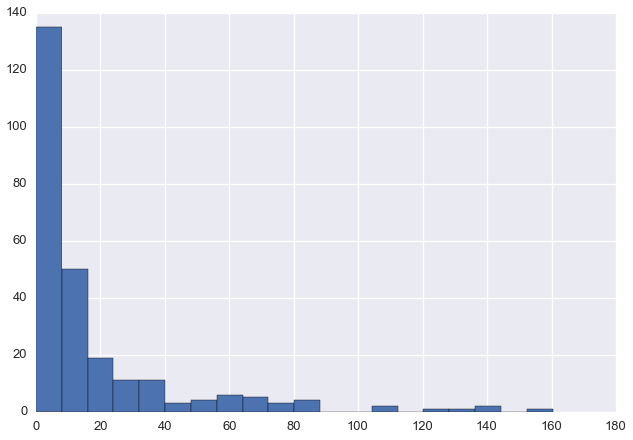

In [28]:
print(p_data_fast.Diff.describe())
plt.hist(p_data_fast.Diff.dropna(), 20);

####Figure 6. Distribution of difference times in the fast condition

Again, we can see that the distribution of difference scores in the fast condition has a number of trials indicating that participants got lost.

In [29]:
# clone p_data_fast for manipulation
d75_fast = p_data_fast.copy()

# remove trials with differences above the 75% cut off
cutoff = d75_fast.Diff.quantile(.75)
columns = list(d75_fast.columns.values)

for c in columns:
    for i, r in d75_fast.iterrows():
        if r[d75_fast.columns.get_loc('Diff')] > cutoff:
            d75_fast.loc[i, c] = np.NaN 

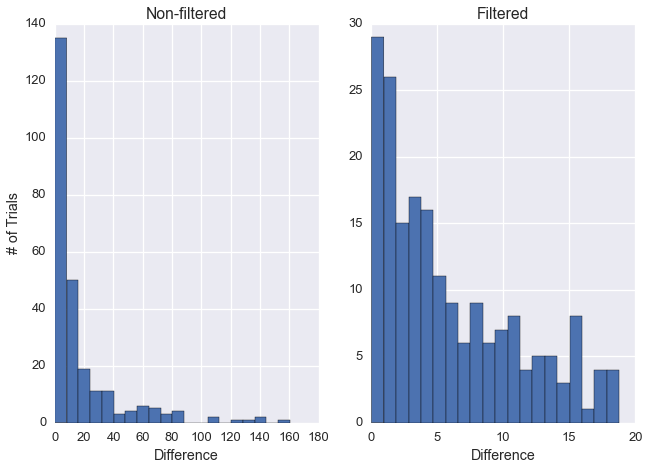

In [30]:
plt.subplot(121)
plt.hist(p_data_fast.Diff.dropna(), 20)
plt.title('Non-filtered')
plt.xlabel('Difference')
plt.ylabel('# of Trials')

plt.subplot(122)
plt.hist(d75_fast.Diff.dropna(), 20)
plt.title('Filtered')
plt.xlabel('Difference');

####Figure 7. Comparison of filtered and non-filtered distributions of difference times in the fast condition

###2.4 Descriptive Statistics

####2.4.1 Task Performance for Slow Movement Condition

In [19]:
# create new dataframe for task variables
t_data_slow = p_data_slow.loc[:, 'Path_Time':'Sim_Time']

# summarize simulation data
t_summary_slow = np.round(t_data_slow.describe(), decimals = 2)

# create table
t_summary_slow

,Path_Time,Distance,RT,Sim_Time
count,258.00,258.00,232.00,258.00
mean,64.54,232.21,3.09,13.41
std,42.84,154.41,1.64,9.82
min,31.00,36.20,0.00,0.19
25%,39.51,141.03,2.04,7.07
50%,52.36,191.73,2.73,11.14
75%,73.83,277.57,3.66,16.56
max,408.01,1445.55,11.82,65.92


####Table 6. Descriptive statistics for task performance in the slow movement condition

####2.4.2 Task Performance for Fast Movement Condition

In [20]:
# create new dataframe for task variables
t_data_fast = p_data_fast.loc[:, 'Path_Time':'Sim_Time']

# summarize simulation data
t_summary_fast = np.round(t_data_fast.describe(), decimals = 2)

# create table
t_summary_fast

,Path_Time,Distance,RT,Sim_Time
count,258.00,258.00,232.00,258.00
mean,42.73,280.92,3.30,11.02
std,27.83,187.25,2.41,7.19
min,17.25,119.76,0.15,0.12
25%,25.44,161.82,2.00,5.59
50%,33.53,220.20,2.74,8.93
75%,47.20,314.38,3.83,14.51
max,179.44,1230.62,21.42,38.35


####Table 7. Descriptive statistics for task performance in the fast movement condition

###2.5 Simulation Statistics

####2.5.1 Slow Movement Condition

In [21]:
# select relevant columns
s_data_slow = p_data_slow.loc[:, 'Vividness':]

# summarize simulation data
s_summary_slow = np.round(s_data_slow.describe(), decimals = 2)

# create table
s_summary_slow

,Vividness,S_coherence,T_coherence,Fract,Coherence,Length,S_mem,G_mem
count,258.00,258.00,258.00,258.00,258.00,258.00,258.00,258.00
mean,3.80,3.53,3.54,3.71,3.62,2.58,4.49,4.22
std,0.90,1.32,1.34,1.15,0.96,1.41,1.03,1.20
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,3.17,3.00,3.00,3.00,3.00,1.00,4.00,4.00
50%,4.00,4.00,4.00,4.00,3.50,2.00,5.00,5.00
75%,4.50,5.00,5.00,4.50,4.50,4.00,5.00,5.00
max,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00


####Table 8. Descriptive statistics for simulation variables in the fast condition

####2.5.2 Fast Movement Condition

In [22]:
# select relevant columns
s_data_fast = p_data_fast.loc[:, 'Vividness':]

#summarize simulation data
s_summary_fast = np.round(s_data_fast.describe(), decimals = 2)

#create table
s_summary_fast

,Vividness,S_coherence,T_coherence,Fract,Coherence,Length,S_mem,G_mem
count,258.00,258.00,258.00,258.00,258.00,258.00,258.00,258.00
mean,3.54,3.29,3.25,3.28,3.28,2.71,4.08,3.71
std,0.99,1.22,1.20,1.08,0.86,1.29,1.21,1.28
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,3.00,2.00,2.00,2.50,2.75,2.00,3.00,3.00
50%,3.67,3.00,3.00,3.00,3.25,3.00,5.00,4.00
75%,4.33,4.00,4.00,4.00,4.00,4.00,5.00,5.00
max,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00


####Table 9. Descriptive statistics for simulation variables in the fast condition

###2.6 Mean Centering Simulation Time

####2.6.1 Slow Movement Condition

In [31]:
# mean center slow condition
mean_center(d75_slow)

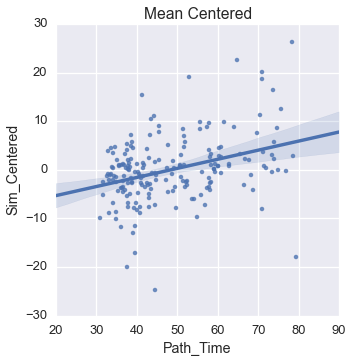

In [32]:
# plot new data
sns.lmplot("Path_Time", "Sim_Centered", d75_slow)
plt.title("Mean Centered");

####Figure 8. Relationship between mean centered simulation time and path time for the slow movement condition

####2.6.2 Fast Movement Condition

In [33]:
# mean center fast data
mean_center(d75_fast)

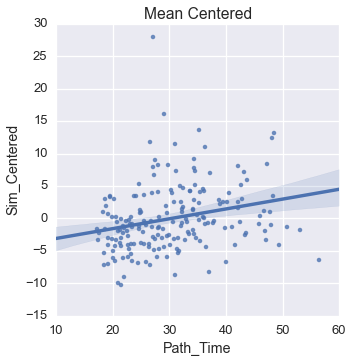

In [34]:
sns.lmplot("Path_Time", "Sim_Centered", d75_fast)
plt.title("Mean Centered");

####Figure 9. Relationship between mean centered simulation time and path time for the fast movement condition

###2.7 Temporal Compression Rate

Next, we need to calculate and compare the temporal compression rates between the three movement conditions. This addresses our second research question about whether the temporal compression rates are adaptive or constant across variations in the speed of visual stimuli encountered while learning spatial layouts. Our hypothesis is that the compression rates will be adaptive to allow more predictions per unit of time during the simulations.

In [35]:
# calculate temporal compression factor
t_fact_slow = d75_slow.loc[:, 'Sim_Time'] / d75_slow.loc[:, 'Path_Time']
print 'The temporal compression factor for the slow movement condition is {} and its standard deviation is {}.'.format(np.round(t_fact_slow.mean(), 3),np.round(t_fact_slow.std(), 3))

The temporal compression factor for the slow movement condition is 0.28 and its standard deviation is 0.188.


In [36]:
# calculate temporal compression factor
t_fact_fast = d75_fast.loc[:, 'Sim_Time'] / d75_fast.loc[:, 'Path_Time']
print 'The temporal compression factor for the fast movement condition is {} and its standard deviation is {}.'.format(np.round(t_fact_fast.mean(), 3), np.round(t_fact_fast.std(), 3))

The temporal compression factor for the fast movement condition is 0.354 and its standard deviation is 0.221.


##3. ANOVA

In this section, we conduct an ANOVA to compare group performance on the performance variables.

In [37]:
# clone dataframes
slow_clone = d75_slow.copy()
medium_clone = d75.copy()
fast_clone = d75_fast.copy()

# insert vector coding group membership
slow_clone['Group'] = 0
medium_clone['Group'] = 1
fast_clone['Group'] = 2

# create new dataframe with all group data
mega = pd.concat([slow_clone, medium_clone, fast_clone])

In [39]:
# export for analysis in SPSS
mega.to_csv('mega_matrix.csv')

![](performance_anova.png)

##4. Comparison of Compression Rates

In this section, we'll compare the compression rates between groups to test whether they're adaptive or constant across encoding speeds. This addresses our research question 2. We also log transform the compression rates in case they result in non-normal distributions.

In [43]:
# insert compression rate vector
mega['Compression'] = mega['Sim_Time']/mega['Path_Time']

# insert log transformed compression rates
mega['Log'] = np.log(mega['Compression'])

In [44]:
# clone vectors for manipulation
c_rates = mega.loc[:,'Group':].copy()

#drop NaN rows
c_rates = c_rates.dropna()

# group based on condition
groups = c_rates.groupby(['Group'])

In [45]:
# test normality of compression and log transforms for each group
group_id = [0,1,2]

for g in group_id:
    data = groups.get_group(g)
    c_values = data.Compression.values
    normal_c = stats.normaltest(c_values)
    print 'For group {} compression values, statistic is {} and p-value is {}'.format(g,normal_c[0],normal_c[1])
    
    # drop NaN values from log vector
    l_values = data.copy()
    l_values = l_values.dropna()
    l_values = l_values.Log.values
    normal_l = stats.normaltest(l_values)
    print 'For group {} log values, statistic is {} and p-value is {}'.format(g,normal_l[0],normal_l[1])

For group 0 compression values, statistic is 50.9097027695 and p-value is 8.81248733691e-12
For group 0 log values, statistic is 46.2536121624 and p-value is 9.03973574066e-11
For group 1 compression values, statistic is 44.3078372503 and p-value is 2.39152755186e-10
For group 1 log values, statistic is 96.5162932181 and p-value is 1.10091355957e-21
For group 2 compression values, statistic is 50.9274317854 and p-value is 8.73471419251e-12
For group 2 log values, statistic is 82.0123856187 and p-value is 1.5532334651e-18


From this output we can see that none of the compression rate vectors are normally distributed and that log transforming them didn't help either. Let's plot this to visualize it better.

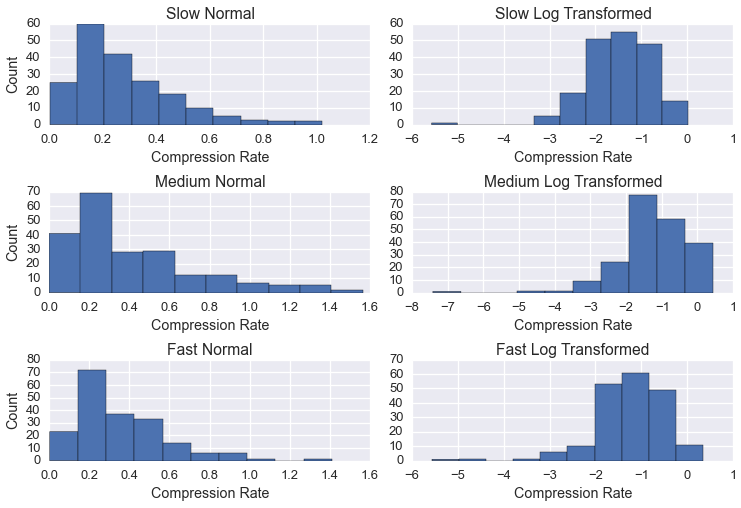

In [47]:
# grab data
c_slow = groups.get_group(0)
c_med = groups.get_group(1)
c_fast = groups.get_group(2)

# plot slow
plt.subplot(321)
plt.hist(c_slow.Compression.values)
plt.title('Slow Normal')
plt.xlabel('Compression Rate')
plt.ylabel('Count')
plt.subplot(322)
plt.hist(c_slow.Log.values)
plt.title('Slow Log Transformed')
plt.xlabel('Compression Rate')

# plot medium
plt.subplot(323)
plt.hist(c_med.Compression.values)
plt.title('Medium Normal')
plt.xlabel('Compression Rate')
plt.ylabel('Count')
plt.subplot(324)
plt.hist(c_med.Log.values)
plt.title('Medium Log Transformed')
plt.xlabel('Compression Rate')

# plot fast
plt.subplot(325)
plt.hist(c_fast.Compression.values)
plt.title('Fast Normal')
plt.xlabel('Compression Rate')
plt.ylabel('Count')
plt.subplot(326)
plt.hist(c_fast.Log.values)
plt.title('Fast Log Transformed')
plt.xlabel('Compression Rate')

plt.tight_layout();

####Figure 10. Comparison of Histograms for Compression Rates and Log Transformed Compression Rates

Based on these plots we can see that although not normal, the compression rates of the three conditions follow the same distribution. As such, to test group differences we'll use the non-parametric Kruskal-Wallis H test.

In [48]:
# run H test on three conditions
H, pval_H = stats.mstats.kruskalwallis(c_slow['Compression'], c_med['Compression'], c_fast['Compression'])
print 'The H statistic is {} and its associated p-value is {}'.format(H,pval_H)

The H statistic is 21.0549046963 and its associated p-value is 2.67907910196e-05


The result of this test shows that there are statistically significant group differences. Next, we'll run the non-parametric Mann-Whiteny U test to identify which groups differ.

In [49]:
# function to run tests
def mw_test(d1, d2, column):
    U, pval_U = stats.mannwhitneyu(d1[column], d2[column])
    # note that the p-value is multiplied by 2 for a two sided test
    print 'For the {} vs {} comparison, the U statistic is {} and its associated p-value is {}'.format(d1['Group'].unique(),d2['Group'].unique(),U,pval_U*2)
    
# run for group comparisons on compression rates
mw_test(c_slow,c_med,'Compression')
mw_test(c_slow,c_fast,'Compression')
mw_test(c_med, c_fast,'Compression')

For the [0] vs [1] comparison, the U statistic is 15486.0 and its associated p-value is 4.29975371633e-05
For the [0] vs [2] comparison, the U statistic is 14426.0 and its associated p-value is 0.000128044592652
For the [1] vs [2] comparison, the U statistic is 19544.0 and its associated p-value is 0.537365472724


From this output we can see that the slow condition has a statistically different compression rate than both the medium and fast conditions, but the medium and fast conditions don't statistically differ from one another.

In [52]:
def dstats(data):
    print 'For the {} condition, the mean compression rate is {} and the standard deviation is {}'.format(data['Group'].unique(),1/data['Compression'].mean(),1/data['Compression'].std())

# display mean and std for each group
dstats(c_slow)
dstats(c_med)
dstats(c_fast)

For the [0] condition, the mean compression rate is 3.57394366397 and the standard deviation is 5.30725345616
For the [1] condition, the mean compression rate is 2.39215859892 and the standard deviation is 3.03959239009
For the [2] condition, the mean compression rate is 2.82791032033 and the standard deviation is 4.51707646079


##5. Regression Analysis

In this section, we run stepwise regression analyses for each movement condition to identify performance and simulation variables that explain a statistically significant amount of variance in the mean centered simulation time. Regression equations are constructed seperately for each condition. As potential predictor variabels, we'll include path time, simulation confidence, vividness, spatial coherence, temporal coherence, fractionation, and post-navigation confidence of the simulation.

###5.1 Regression Equation for Slow Movement Condition

Because these analyses were run in SPSS, they'll be imported as images from the SPSS output.

**Note that the full SPSS output is available in the project Github repo.**

![](slow_reg_results.png)

####Figure 11. Regression output for slow movement condition

Our analysis identified a statistically significant regression equation that includes both path time and simulation confidence as predictor variables. Importantly, the longer the subsequent path time, the longer the simulation episode, reflecting that temporal information is retained (in a compressed form) during mental simulations.

###5.2 Regression Equation for the Medium Movement Condition

![](medium_reg_results.png)

####Figure 12. Regression output for medium movement condition

For the medium condition, we also found a statistically significant regression equation. As with the slow condition, the first predictor variable in the equation is path time. However, in this condition we also have a statistically significant predictor variable representing the fidelity of the memories being used to imagine the route. For vividness, the higher the variables (i.e. the more vivid the memories), the quicker participants are able to simulate the routes. This addresses research Q3 and shows that the better the fidelity of the spatial memories, the more readily participants are able to simulate routes based on them.

###5.3 Regression Equation for the Fast Movement Condition

![](fast_reg_results.png)

####Figure 13. Regression output for fast movement condition

As in both other movement conditions, we have a statistically significant regression equation with path time as the first predictor variable. We also find an effect of memory fidelity here with more spatially coherent memories facilitating quicker mental simulations.

###5.4 Regression Plots

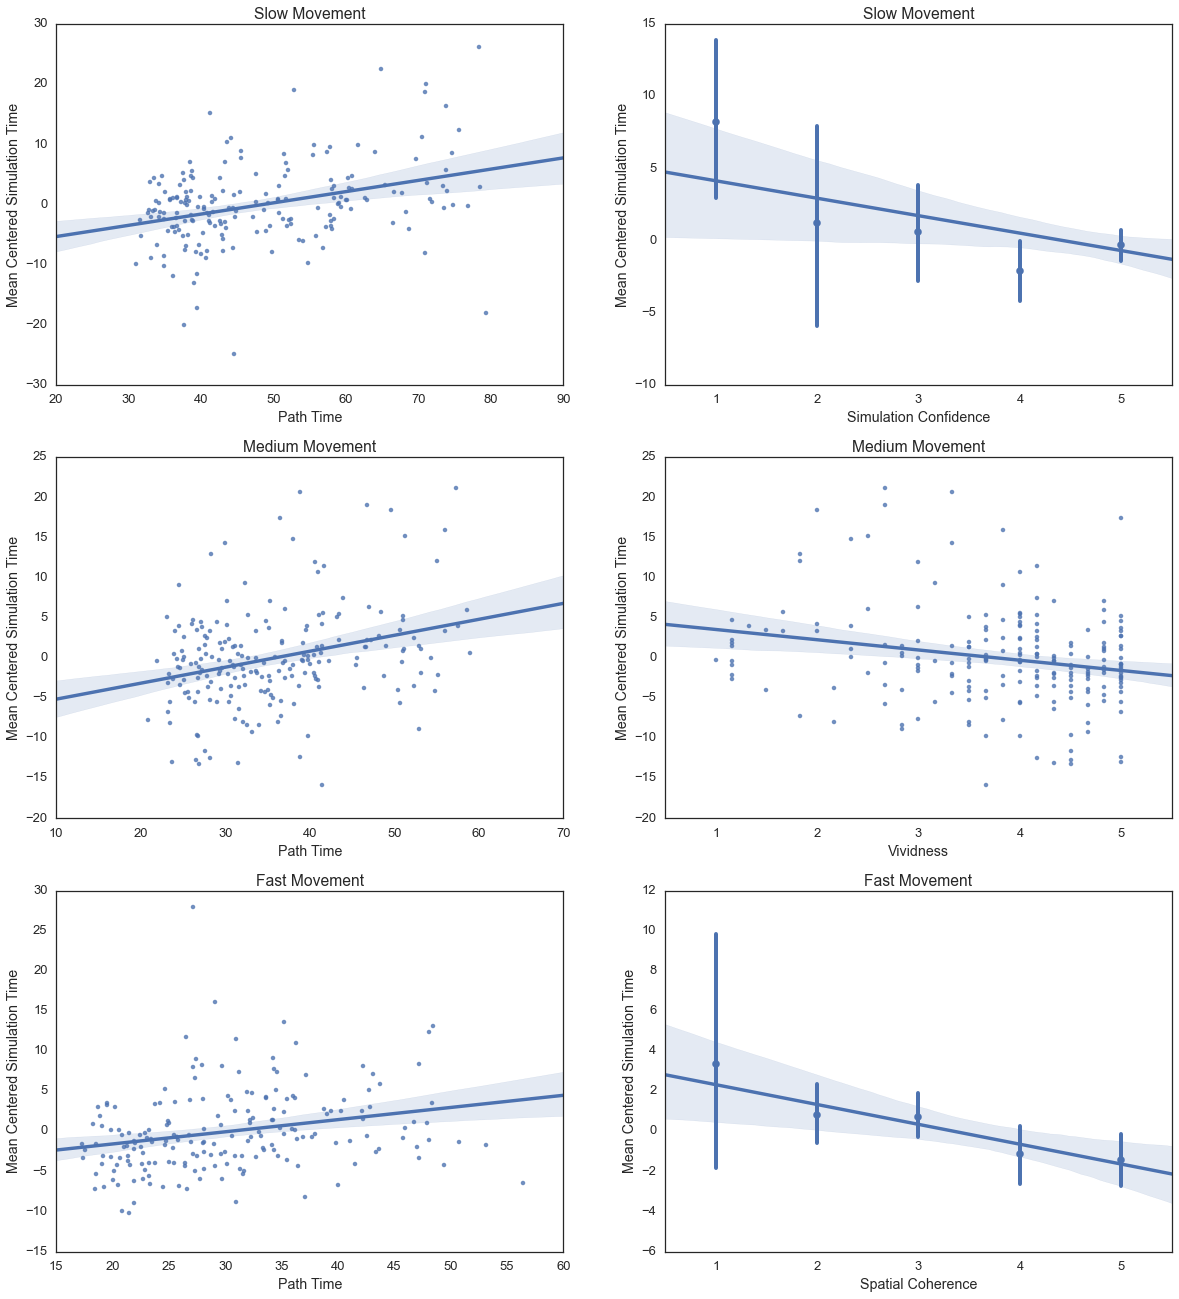

In [119]:
# define figure properties
sns.set_style('white')
sns.set_context('talk')
f, ax = plt.subplots(figsize=(20, 22))

plt.subplot(321)
sns.regplot('Path_Time', 'Sim_Centered', d75_slow)
plt.ylabel('Mean Centered Simulation Time')
plt.xlabel('Path Time')
plt.title('Slow Movement')

plt.subplot(322)
sns.regplot('Sim_con', 'Sim_Centered', d75_slow, x_estimator=np.mean)
plt.ylabel('Mean Centered Simulation Time')
plt.xlabel('Simulation Confidence')
plt.title('Slow Movement')
plt.xlim(.5,5.5)

plt.subplot(323)
sns.regplot('Path_Time', 'Sim_Centered', d75)
plt.ylabel('Mean Centered Simulation Time')
plt.xlabel('Path Time')
plt.title('Medium Movement')

plt.subplot(324)
sns.regplot('Vividness', 'Sim_Centered', d75)
plt.ylabel('Mean Centered Simulation Time')
plt.xlabel('Vividness')
plt.title('Medium Movement')
plt.xlim(.5,5.5)

plt.subplot(325)
sns.regplot('Path_Time', 'Sim_Centered', d75_fast)
plt.ylabel('Mean Centered Simulation Time')
plt.xlabel('Path Time')
plt.title('Fast Movement')

plt.subplot(326)
sns.regplot('S_coherence', 'Sim_Centered', d75_fast, x_estimator=np.mean)
plt.ylabel('Mean Centered Simulation Time')
plt.xlabel('Spatial Coherence')
plt.xlim(.5,5.5)
plt.title('Fast Movement');

####Figure 14. Plots showing relationship between predictors and simulation time for each movement condition